# Milestone 2 - CasierVert952

## 0. Initial configuration

### 0.1 Data preprocessing

In this phase, we will start by demonstrating how we transformed the ```TXT``` ratings files (for both BA and RB) into CSV format. Next, we will merge the various data files and rename the columns to create a dataframes containing all available feature for each of the datasets. Afterward we will clean and modify some features such as dates and locations to meet our needs. Finally, we will save the cleaned data into ```CSV``` files to be able to load them quickly.

This step can be found on [data_preprocessing.ipynb](data_preprocessing.ipynb), which has to be entirely executed once to be able to run the following cells.

The ```data``` directory should now look like this :

```
data/
├── BeerAdvocate
│   ├── beers.csv
│   ├── breweries.csv
│   ├── users.csv
│   ├── ratings.csv
│   └── BA_cleaned.csv
│
└── RateBeer
    ├── beers.csv
    ├── breweries.csv
    ├── users.csv
    ├── ratings.csv
    └── RB_cleaned.csv
```

### 0.2 Importation of libraries and golbal variable declarations

In [1]:
# import the basic requiered libraries
import os
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# path variables
BA_DATA_PATH = "data/BeerAdvocate/"
RB_DATA_PATH = "data/RateBeer/"

import importlib
import helpers
importlib.reload(helpers)

<module 'helpers' from 'C:\\Users\\Fabian Roulin\\Desktop\\git\\ada-2024-project-casiervert952\\helpers.py'>

## 1. Data loading and visualization

### 1.1 Loading cleaned data

The preprocessing task having already been done, the cleaned data just has to be loaded.

In [2]:
# create Dataframes for the BA cleaned data
s_time = time.time()
BA_cleaned = pd.read_csv(BA_DATA_PATH + 'BA_cleaned.csv', low_memory=False)
e_time = time.time()
print("Loading of BA data ended in " + str(e_time - s_time) + " seconds.")

# create Dataframes for the RB cleaned data
s_time = time.time()
RB_cleaned = pd.read_csv(RB_DATA_PATH + 'RB_cleaned.csv', low_memory=False)
e_time = time.time()
print("Loading of RB data ended in " + str(e_time - s_time) + " seconds.")

# loading extra data useful for "Data exploration"
BA_beers = pd.read_csv(BA_DATA_PATH + 'beers.csv')
BA_breweries = pd.read_csv(BA_DATA_PATH + 'breweries.csv')
BA_users = pd.read_csv(BA_DATA_PATH + 'users.csv')
RB_beers = pd.read_csv(RB_DATA_PATH + 'beers.csv')
RB_breweries = pd.read_csv(RB_DATA_PATH + 'breweries.csv')
RB_users = pd.read_csv(RB_DATA_PATH + 'users.csv')

Loading of BA data ended in 44.36109471321106 seconds.
Loading of RB data ended in 31.98400044441223 seconds.


### 1.2 Data visualization

The following illustrates the structure of our data after preprocessing. In the future we will refine our data,and then for the analyses we will create derived DataFrames from ```BA_cleaned``` and ```RB_cleaned``` by copying them and then, removing, modifying, and adding features to these copies as needed.

In [3]:
# display 3 samples of the BA dataset
print("Visualization of BA :")
display(BA_cleaned.sample(3).T)

# display 3 samples of the RB dataset
print("\nVisualization of RB :")
display(RB_cleaned.sample(3).T)

Visualization of BA :


,1510599,3803097,736997
rating_date,01-2012,12-2015,10-2014
rating_appearance,4.0,4.0,NaN
rating_aroma,4.0,3.75,NaN
rating_palate,4.0,3.75,NaN
rating_taste,3.5,4.0,NaN
rating_overall,3.5,4.0,NaN
rating,3.7,3.92,3.75
beer_id,75435,2264,65223
beer_name,Samuel Adams Mighty Oak Ale,Brown Shugga',72 Imperial Chocolate Cream Stout
beer_style,American Amber / Red Ale,American Strong Ale,Milk / Sweet Stout



Visualization of RB :


,2597675,6102254,5710787
rating_date,04-2007,01-2015,07-2013
rating_appearance,3,4,4
rating_aroma,6,8,8
rating_palate,3,4,4
rating_taste,7,7,8
rating_overall,13,16,17
rating,3.2,3.9,4.1
beer_id,7544,33334,218901
beer_name,Evans Chocolate Porter,Baden Baden Red Ale Especial,Great Divide Yeti Imperial Stout - Oatmeal
beer_style,Porter,Barley Wine,Imperial Stout


> *Here, it can be seen that there is the user's information and his rating on a particular beer. Attached to that, there is a variety of data about the beer characteristics and a varity of information about its corresponding brewery. It can also be seen that, sometimes, some data are missing, the fields are empty (NaN).*

## 2. Data exploration of the two beers' datasets 

Indeed, we are given two different but very similar datasets to perform our analysis. Let's begin by examining them to determine the best approach: using one dataset, combining both, or creating a blend of the two.


### 2.1 Sizes

We will first look into their size.

In [4]:
# print sizes of each Dataframe for both datasets.
print("BA :")
print("   Number of ratings   : " + str(BA_cleaned.shape[0]))
print("   Number of beers     : " + str(BA_beers.shape[0]))
print("   Number of breweries : " + str(BA_breweries.shape[0]))
print("   Number of users     : " + str(BA_users.shape[0]))

print("\nRB :")
print("   Number of ratings   : " + str(RB_cleaned.shape[0]))
print("   Number of beers     : " + str(RB_beers.shape[0]))
print("   Number of breweries : " + str(RB_breweries.shape[0]))
print("   Number of users     : " + str(RB_users.shape[0]))

BA :
   Number of ratings   : 8392192
   Number of beers     : 280823
   Number of breweries : 16758
   Number of users     : 153704

RB :
   Number of ratings   : 7123070
   Number of beers     : 442081
   Number of breweries : 24189
   Number of users     : 70174


> *The RB dataset contains more data on different beers and breweries, but less users than the BA one. Both datasets have around 7 millions user's ratings, which seems at first sight enough to perfom our analysis.*

### 2.2 Missing values

We will check how many value are missing the features columns. It will help us to decide what to remove during the "Data refinement" phase.

In [5]:
# compute missing values by columns
missing_count_BA = BA_cleaned.isna().sum()
missing_percentage_BA = (missing_count_BA / len(BA_cleaned)) * 100
missing_count_RB = RB_cleaned.isna().sum()
missing_percentage_RB = (missing_count_RB / len(RB_cleaned)) * 100

# put results in a dataframe
missing_data_BA = pd.DataFrame({
    'Column': BA_cleaned.columns,
    'Missing Values (BA)': missing_count_BA,
    '% (BA)': missing_percentage_BA
})
missing_data_RB = pd.DataFrame({
    'Column': RB_cleaned.columns,
    'Missing Values (RB)': missing_count_RB,
    '% (RB)': missing_percentage_RB
})

# sort by "%"
missing_data_BA = missing_data_BA.sort_values(by='% (BA)', ascending=False)
missing_data_RB = missing_data_RB.sort_values(by='% (RB)', ascending=False)

# print the results for both datasets (one after the other)
display(missing_data_BA, missing_data_RB)

,Column,Missing Values (BA),% (BA)
beer_avg_matched_valid_ratings,beer_avg_matched_valid_ratings,7464671,88.947810
beer_zscore,beer_zscore,7436327,88.610068
beer_bros_score,beer_bros_score,5283785,62.960726
rating_aroma,rating_aroma,3622979,43.170831
rating_palate,rating_palate,3622979,43.170831
rating_taste,rating_taste,3622979,43.170831
rating_overall,rating_overall,3622979,43.170831
rating_appearance,rating_appearance,3622979,43.170831
breweries_state,breweries_state,1481852,17.657508
user_state,user_state,1089052,12.976967


,Column,Missing Values (RB),% (RB)
beer_zscore,beer_zscore,6102391,85.670799
beer_avg_matched_valid_ratings,beer_avg_matched_valid_ratings,6102391,85.670799
breweries_state,breweries_state,4111124,57.715620
user_state,user_state,4014385,56.357512
overall_score,overall_score,861022,12.087794
style_score,style_score,844833,11.860518
user_country,user_country,203670,2.859301
user_location,user_location,203670,2.859301
beer_abv,beer_abv,174964,2.456300
user_join_date,user_join_date,2625,0.036852


> *Here, we see that our data of interest (mainly user_location, breweries locations and ratings) have some missing values in the user_location column, meaning these ratings will have to get discarded later. Additionnaly, we see that breweries_state and user_state are sometimes missing but this is normal because sometimes the user might not be located in the US (state not precised in this case).*

### 2.3 Country Representation

To be able to have a proper study on the influence of politics on beer appreciation, we need to investigate the representation of countries in both datasets. This will assist us in selecting the most appropriate political datasets for our final analyses.

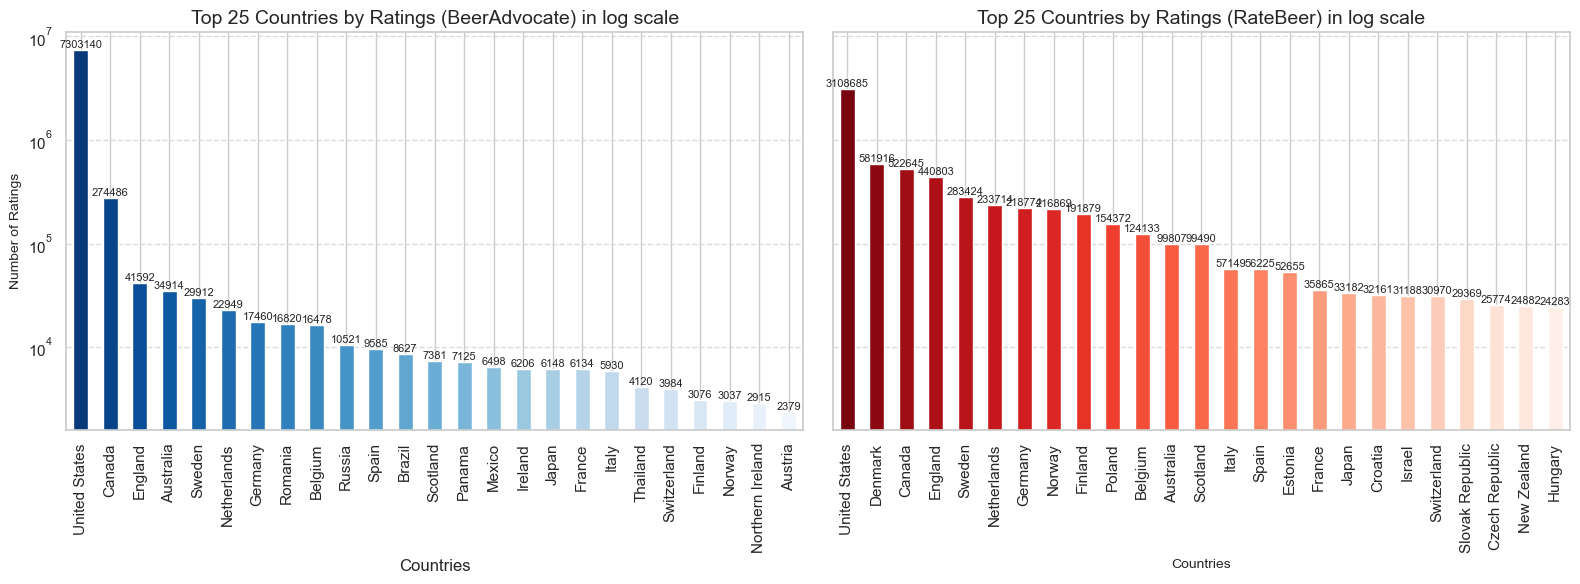

In [6]:
from helpers import ploting_country_representation

# compute number of ratings per country
BA_count_per_country = BA_cleaned.groupby('user_country').size().nlargest(25)
RB_count_per_country = RB_cleaned.groupby('user_country').size().nlargest(25)

ploting_country_representation(BA_count_per_country, RB_count_per_country, 'log')

In [7]:
# top 10 country ratings with precise values
country_comparison = pd.DataFrame({
    'Country (BA)': BA_count_per_country.index,
    '# of Ratings (BeerAdvocate)': BA_count_per_country.values,
    '% of Ratings (BeerAdvocate)': np.round(BA_count_per_country.values / len(BA_cleaned) * 100, 2),
    'Country (RB)': RB_count_per_country.index,
    '# of Ratings (RateBeer)': RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values,
    '% of Ratings (RateBeer)': np.round(RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values / len(RB_cleaned) * 100, 2)
})
country_comparison.index = range(1, len(country_comparison) + 1)
country_comparison.head(10)

,Country (BA),# of Ratings (BeerAdvocate),% of Ratings (BeerAdvocate),Country (RB),# of Ratings (RateBeer),% of Ratings (RateBeer)
1,United States,7303140,87.02,United States,3108685,43.64
2,Canada,274486,3.27,Denmark,581916,8.17
3,England,41592,0.50,Canada,522645,7.34
4,Australia,34914,0.42,England,440803,6.19
5,Sweden,29912,0.36,Sweden,283424,3.98
6,Netherlands,22949,0.27,Netherlands,233714,3.28
7,Germany,17460,0.21,Germany,218774,3.07
8,Romania,16820,0.20,Norway,216869,3.04
9,Belgium,16478,0.20,Finland,191879,2.69
10,Russia,10521,0.13,Poland,154372,2.17


> *We see that most of the ratings for both sites comes from USA and Canada first and then from European countries. This means that the project will focus mainly on politics from US/Canada and European countries. To be sure that we are not losing too much data from other continents, we will compute the percentage of ratings coming from US/Canada together and Europe together.*

In [8]:
# importing lists of countries for europe and north america
from helpers import european_countries, north_america_countries

# NA: compute total % of ratings for BeerAdvocate
na_BA_percentage = country_comparison[country_comparison['Country (BA)'].isin(north_america_countries)]['% of Ratings (BeerAdvocate)'].sum()
print('NA:\n   Total % of ratings (BA) :', round(na_BA_percentage,1), '%')

# NA: compute total % of ratings for RateBeer
na_RB_percentage = country_comparison[country_comparison['Country (RB)'].isin(north_america_countries)]['% of Ratings (RateBeer)'].sum()
print('   Total % of ratings (RB) :', round(na_RB_percentage,1), '%')

# EU: compute total % of ratings for BeerAdvocate
BA_european_percentage = country_comparison[country_comparison['Country (BA)'].isin(european_countries)]['% of Ratings (BeerAdvocate)'].sum()
print('\nEU:\n   Total % of ratings (BA) :', round(BA_european_percentage,1), '%')

# EU: compute total % of ratings for RateBeer
RB_european_percentage = country_comparison[country_comparison['Country (RB)'].isin(european_countries)]['% of Ratings (RateBeer)'].sum()
print('   Total % of ratings (RB) :', round(RB_european_percentage,1), '%')

# compute and print total loss of ratings coming from other continents for both datasets
BA_total_loss = 100 - na_BA_percentage - BA_european_percentage
print ("\nOther continents (loss):\n   Total % of ratings (BA) :", round(BA_total_loss,1), '%' )
RB_total_loss = 100 - na_RB_percentage - RB_european_percentage
print ("   Total % of ratings (RB) :", round(RB_total_loss,1), '%' )

NA:
   Total % of ratings (BA) : 90.3 %
   Total % of ratings (RB) : 51.0 %

EU:
   Total % of ratings (BA) : 2.3 %
   Total % of ratings (RB) : 38.7 %

Other continents (loss):
   Total % of ratings (BA) : 7.4 %
   Total % of ratings (RB) : 10.3 %


**Observations for BeerAdvocate :**

    - 90.3% of ratings from North America, 87% from US
    - 2.3% of ratings from Europe
    - 7.4% of ratings from other continents

> As our goal is to find relations between politics orientations and beers habits, we see that this datasets can help us to do it for north america (US and Canada) since most of ratings come from there. Meanwhile this dataset might not be adequate for Europe since it only represents 2.3% of the users's ratings. Here, the data that won't be used is about 9.7% (EU and Others), which is pretty significant.


**Observations for RateBeer :**

    - 51% of ratings from North America, 43.6% from US
    - 38.7% of ratings from Europe
    - 10.3% of ratings from other continents

> This means that for this dataframe we will be able to have a proper analysis about US/Canada and Europe since they are both around 40%. The data that won't be used represent 10% of the datasets which is again pretty significant.

### 2.4 Ratings distribution over users

It is also interesting to explore the quantity of ratings that each user has published. Do we give more importance to regular users than to occasional ones ? Are users who have thousands and thousands of ratings relevant ? Are theses users biasing our result ?

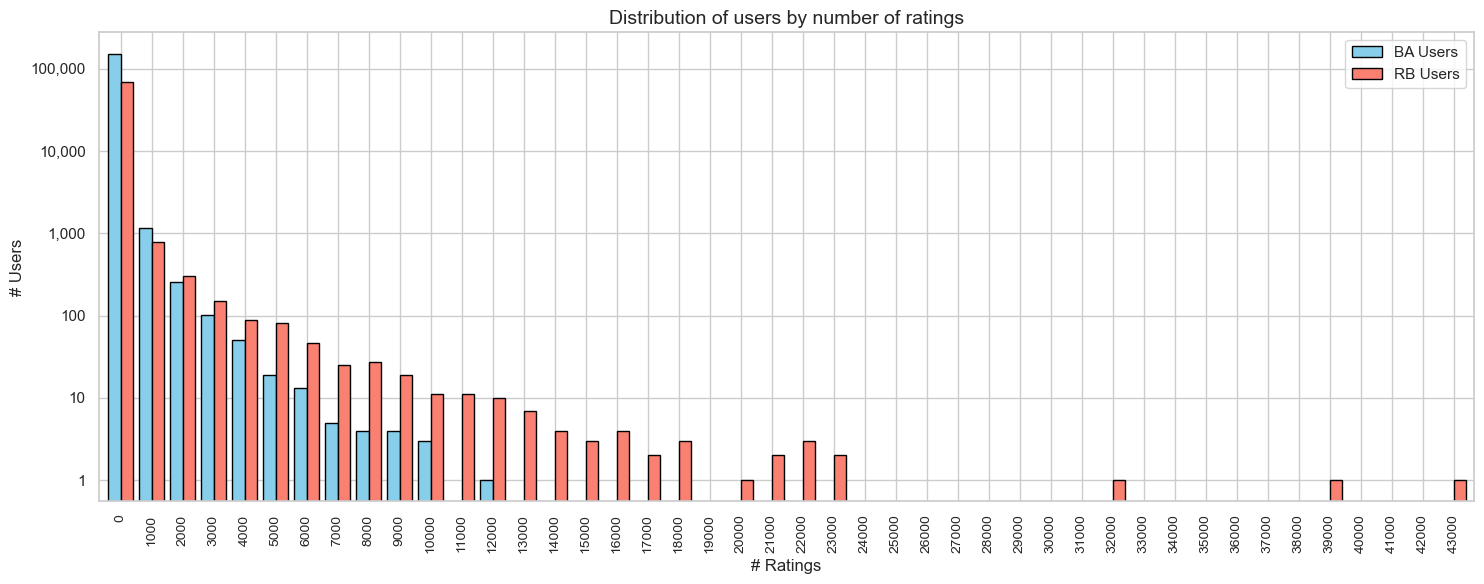

In [9]:
from helpers import ploting_user_ratings_distribution

# Computing the #ratings by users, and grouping them in bins of size 1000
BA_ratings_by_user = BA_cleaned.groupby('user_id').size().reset_index(name='#ratings')
BA_ratings_bins = pd.cut(BA_ratings_by_user['#ratings'], bins=np.arange(0, BA_ratings_by_user['#ratings'].max() + 1000, 1000))
BA_ratings_bins = BA_ratings_bins.value_counts().sort_index()

RB_ratings_by_user = RB_cleaned.groupby('user_id').size().reset_index(name='#ratings')
RB_ratings_bins = pd.cut(RB_ratings_by_user['#ratings'], bins=np.arange(0, RB_ratings_by_user['#ratings'].max() + 1000, 1000))
RB_ratings_bins = RB_ratings_bins.value_counts().sort_index()

# Only show the minial value of the bins in the graph
BA_ratings_bins.index = [f'{int(bin.left)}' for bin in BA_ratings_bins.index]
RB_ratings_bins.index = [f'{int(bin.left)}' for bin in RB_ratings_bins.index]

# Ploting the #ratings by users data
ploting_user_ratings_distribution(BA_ratings_bins, RB_ratings_bins)

> We observe that the distribuition of the BA datasets is smoother than the RB one. For the RB datasets, we notice around ten people above the 20,000 reviews, these people can be the origin of bias in our results as they have put so many ratings.

### 2.5 Ratings distribution over months

In our analyses, we will compare political properties with beer properties over time. It is important to examine the distribution of ratings across different months to ensure the relevance and validity of our results.

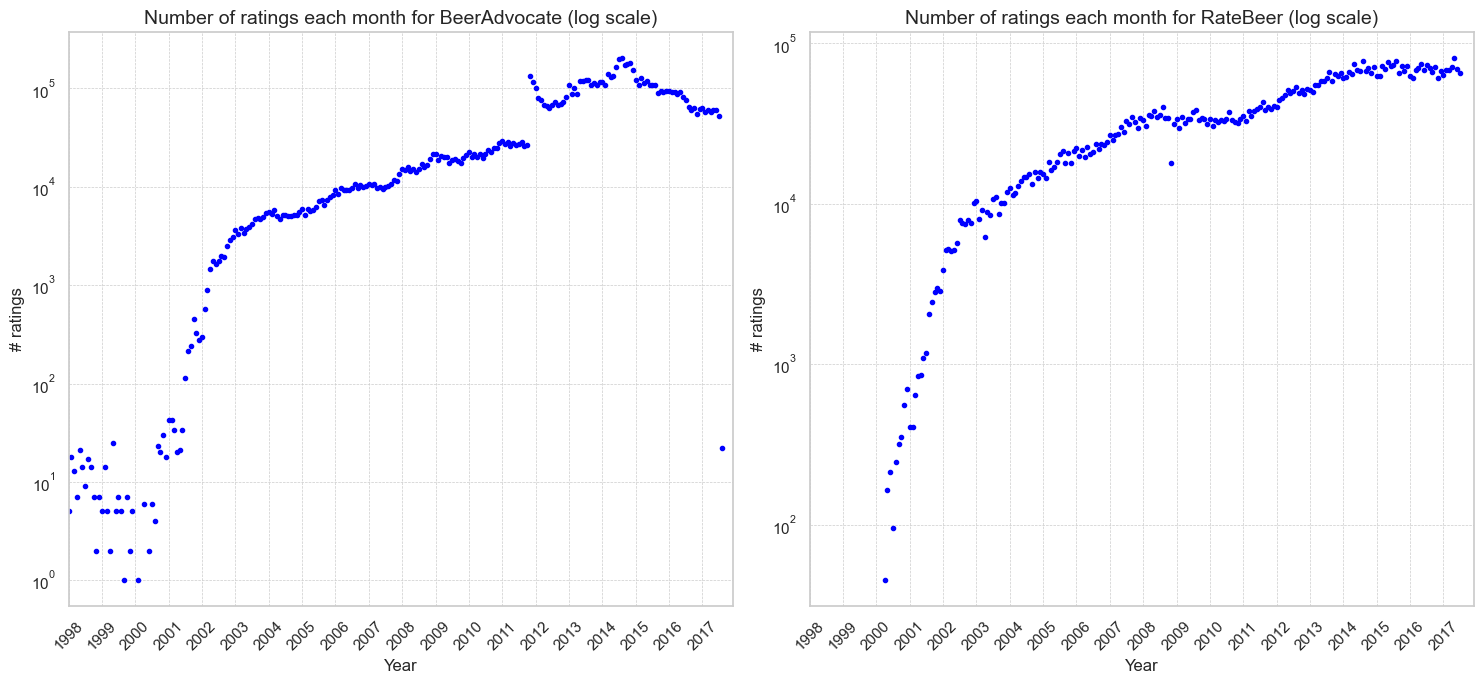

In [10]:
from helpers import ploting_ratings_by_month

# compute the #ratings by month
BA_ratings_by_month = BA_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
BA_ratings_by_month['rating_date'] = pd.to_datetime(BA_ratings_by_month['rating_date'], format='%m-%Y')

RB_ratings_by_month = RB_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
RB_ratings_by_month['rating_date'] = pd.to_datetime(RB_ratings_by_month['rating_date'], format='%m-%Y')

# plot the #ratings by months data
ploting_ratings_by_month(BA_ratings_by_month, RB_ratings_by_month, "log")

**For BeerAdvocate :**

> *Before 2002, the number of user ratings each month is very low (under 1000), which may pose problems for conducting a reliable statistical analysis. On the contrary, starting from 2007, there are more than 10,000 ratings per month, providing a solid foundation for more precise analysis. It can also be noted that starting from 2012, the data shows significant volatility, with the number of ratings varying greatly from one month to the next one.*

**For RateBeer :**

> *Before 2003, there is limited data, but after that year, the graph shows a consistent increase of data every month. This suggests that we can have more confidence in our results for the later years.*

## 3. US Politics external datasets processing

As we saw before, the majority of the ratings came from the USA for both websites. Thus, the first analysis will be on US politics.

### 3.1 Data loading

In [11]:
# create a dataframe containing the number of votes for each candidate for each US state
us_pres_df = pd.read_csv('./data/US president/1976-2020-president.csv')
us_pres_df = us_pres_df.loc[us_pres_df.year>1998].reset_index()

# get the % of vote
us_pres_df['vote_percent']=us_pres_df['candidatevotes']/us_pres_df['totalvotes']*100

# print to get a look
us_pres_df.head()

,index,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,vote_percent
0,2042,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"BUSH, GEORGE W.",REPUBLICAN,False,941173,1666272,20210113,NaN,REPUBLICAN,56.483755
1,2043,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"GORE, AL",DEMOCRAT,False,692611,1666272,20210113,NaN,DEMOCRAT,41.566503
2,2044,2000,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,INDEPENDENT,False,25896,1666272,20210113,NaN,OTHER,1.554128
3,2045,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"BROWNE, HARRY",LIBERTARIAN,False,5893,1666272,20210113,NaN,LIBERTARIAN,0.353664
4,2046,2000,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,NaN,True,699,1666272,20210113,NaN,OTHER,0.041950


Here we can see that there are multiple candidates for the elections which means that we won't be able to take 100% of the votes because we will only be considering Republican votes or Democrat votes.

### 3.2 Computing Republicans score percentage by state/year

In [12]:
# extract only the republican results
republican_score=us_pres_df.loc[us_pres_df['party_simplified']=='REPUBLICAN'].copy().reset_index()

# create a dataframe with row=states and column=election year.
rep_year_score_df=republican_score.pivot_table(index='state_po',columns='year',values='vote_percent',aggfunc='sum')

#useful for following part
rep_year_ = republican_score.pivot_table(index=('state_po','state'),columns='year',values='vote_percent',aggfunc='sum')

# add a column with average percent result over 2000-2020
rep_year_score_df['Average']=rep_year_score_df.mean(axis=1)
rep_year_['Average']=rep_year_.mean(axis=1)
rep_year_ = rep_year_.sort_values(by='Average',ascending=False)

# display the top 5 most republican states over 6 elections
rep_year_score_df.sort_values(by='Average',ascending=False).head(5)

year,2000,2004,2008,2012,2016,2020,Average
state_po,,,,,,,
WY,69.222743,68.739569,64.713775,68.193585,67.398411,69.499790,67.961312
OK,60.307852,65.570402,65.645081,66.772320,65.322865,65.373272,64.831965
ID,67.170439,68.390945,61.517091,64.529783,59.261432,63.837565,64.117876
UT,66.830143,71.535948,62.583870,72.790533,45.540817,58.129839,62.901858
AL,56.483755,62.460690,60.316913,60.545822,62.083092,62.031643,60.653653


> We see that the states that vote much more republican than democrat are Wyoming, Oklahoma,Idaho, Utah and Alabama

### 3.3 Computing Democrats score percentage by state/year

In [13]:
# extract only the democrat results
democrat_score=us_pres_df.loc[us_pres_df['party_simplified']=='DEMOCRAT'].copy().reset_index()

# create a dataframe with row=states and column=election year.
dem_year_score_df=democrat_score.pivot_table(index='state_po',columns='year',values='vote_percent',aggfunc='sum')

# doing some preprocessing
dem_year_ = democrat_score.pivot_table(index=('state_po','state'),columns='year',values='vote_percent',aggfunc='sum')
dem_year_['Average']=dem_year_.mean(axis=1)
dem_year_ = dem_year_.sort_values(by='Average',ascending=False)

# add a column with average percent result over 2000-2020
dem_year_score_df['Average']=dem_year_score_df.mean(axis=1)

# display the top 5 most democrat states over 6 elections
dem_year_score_df.sort_values(by='Average',ascending=False).head(10)

year,2000,2004,2008,2012,2016,2020,Average
state_po,,,,,,,
DC,85.155081,89.183869,92.457110,90.913114,90.483884,92.149694,90.057125
HI,55.791668,54.009552,71.452910,70.147932,60.980798,63.149380,62.588707
MA,59.126126,61.616660,61.363199,60.338308,59.050065,65.122984,61.102890
VT,50.634709,58.937463,67.455683,66.570550,55.722742,65.455781,60.796155
MD,56.488308,55.971761,61.919345,61.974191,60.328549,65.360665,60.340470
RI,60.987700,59.423426,62.864005,62.700959,54.406607,59.476199,59.976483
CA,53.449737,54.305558,61.012638,60.238959,61.726400,63.483947,59.036206
NY,56.639270,56.130581,60.156962,60.760984,56.136143,60.391885,58.369304
CT,55.909628,54.313709,60.588830,58.085013,54.566301,59.260732,57.120702


> We see that the states that vote much more democrat than republican are DC, Hawaii, Massachusetts, Vermont and Maryland

### 3.4 Other parties score percentage by state/year

In [14]:
# extract only the other results
other_score=us_pres_df.loc[us_pres_df['party_simplified']=='OTHER'].copy().reset_index()

# create a dataframe with row=states and column=election year.
other_year_score_df=other_score.pivot_table(index='state_po',columns='year',values='vote_percent',aggfunc='sum',fill_value=0)

# add a column with average percent result over 2000-2020
other_year_score_df['Average']=other_year_score_df.mean(axis=1)

# display the top 5 of the states that vote for independant candidates
other_year_score_df.sort_values(by='Average',ascending=False).head()

year,2000,2004,2008,2012,2016,2020,Average
state_po,,,,,,,
NY,10.801017,6.027054,8.272034,7.335715,10.737016,1.451418,7.437376
UT,6.355984,2.104664,2.278946,1.224151,23.496863,1.640810,6.183570
AK,12.789606,2.881976,2.198978,1.925822,6.290489,1.920285,4.667859
VT,8.401742,1.908366,1.766827,1.291724,11.373090,3.190572,4.655387
ME,6.470528,1.585416,1.910244,3.011212,5.241536,2.214643,3.405597


> New york and Utah are the only two states where the other parties make more than 5% on average

### 3.5 Computing difference in voting percentage

In [15]:
# create a dataframe of percent difference in results between democrats and republican.
# positive indicates republican perform better, negative indicates democrats perform better
delta_df = rep_year_score_df-dem_year_score_df

# add a column of average difference over the years
delta_df['Average']=delta_df.mean(axis=1)

# display it
delta_df.head()


year,2000,2004,2008,2012,2016,2020,Average
state_po,,,,,,,
AK,30.954615,25.548468,21.535146,13.988918,14.730641,10.061191,19.469830
AL,14.917252,25.616287,21.576479,22.186789,27.725147,25.461653,22.913935
AR,5.442941,9.758329,19.851245,23.687946,26.920978,27.620668,18.880351
AZ,6.286553,10.472601,8.519997,9.064766,3.543962,-0.308710,6.263195
CA,-11.798240,-9.947862,-24.057780,-23.118581,-30.109293,-29.163223,-21.365830


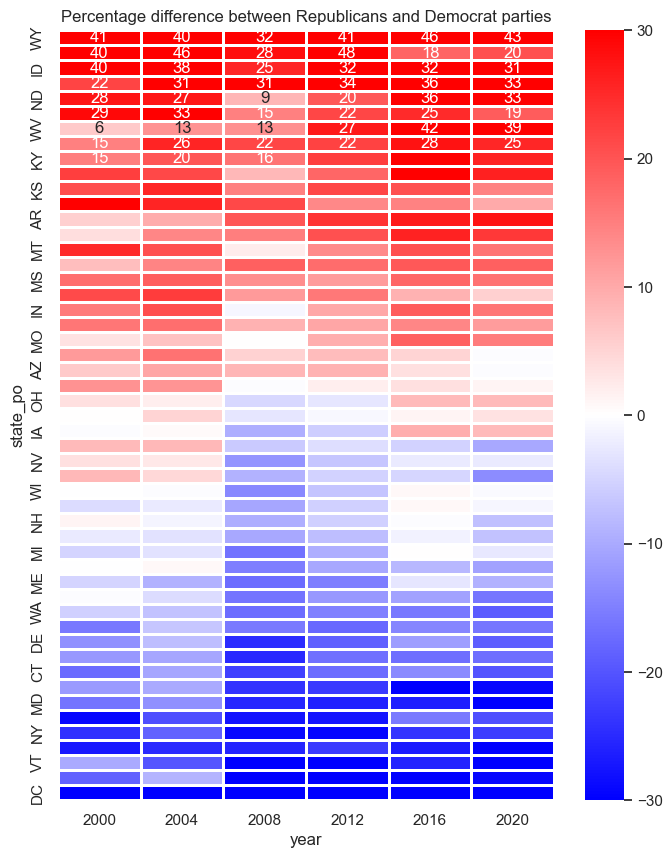

In [16]:
# display heatmap showing the percentages of voters for republicans (red) and democrats (blue) for each state for each election year
plt.figure(figsize=(8,10))
sns.heatmap(data=delta_df.sort_values(by='Average',ascending=False).drop('Average',axis=1),linewidths=0.8,cmap='bwr',vmax=30,vmin=-30,center=0, annot=True,fmt='.0f').set_title('Percentage difference between Republicans and Democrat parties');

Here, we can identify three top 5 :

    - Top 5 most Republican states
    - Top 5 most Democrat states
    - Top 5 most swing states (states that hesitate the most for which parti to vote for)

In [17]:
# top 5 most republican states
rep_df = rep_year_score_df.sort_values(by='Average',ascending=False).head(5)

# top 5 most democrat states
dem_df = dem_year_score_df.sort_values(by='Average',ascending=False).head(5)

## 4. Data refinement

In this section, we will discuss our choice of removing some features and some ratings elements due to the quality of the data and the needs we have for it.

### 4.1 Dropping ratings with the user's location not available (NaN)

In [18]:
# see how much data will be lost by dropping NaN for user_location
BA_unavailable_user_loc = BA_cleaned['user_location'].isna().mean() * 100
RB_unavailable_user_loc  = RB_cleaned['user_location'].isna().mean() * 100

print(f'BeerAdvocate cleaned dataframe (BA_cleaned) has {BA_unavailable_user_loc:.1f}% unavailable data for user location')
print(f'RateBeer cleaned dataframe (RB_cleaned) has {RB_unavailable_user_loc:.1f}% unavailable data for user location')

BeerAdvocate cleaned dataframe (BA_cleaned) has 6.0% unavailable data for user location
RateBeer cleaned dataframe (RB_cleaned) has 2.9% unavailable data for user location


Here, we can see that the amount of data that will get discarded is not negligeable but doesn't affect too much our dataset too. The contry in which the ratings where made is crucial for our analysis, so we decided to remove the ratings where the country field is missing.

In [19]:
# dropping the elements with no user_location
BA_refined = BA_cleaned.dropna(subset = ['user_location'])
RB_refined = RB_cleaned.dropna(subset = ['user_location'])

### 4.... Create dataframe of only US users

Now, for the purpose of the next section, we create a Dataframe containing only the ratings of US residents.

In [51]:
# create Dataframe of only USA users
BA_usa = BA_refined.copy().loc[BA_cleaned['user_country'].str.contains('United States', case=False, na=False)]
RB_usa = RB_refined.copy().loc[RB_cleaned['user_country'].str.contains('United States', case=False, na=False)]

## 5. Analysis : Relation Beer vs Political

### 5.1 US states' their prefered consumption type

In [21]:
# determine if the user is consuming a beer locally (from a brewery in its own state), nationally (US brewery) or internationnally (foreign brewery)
BA_usa['consumption_type'] = BA_usa.apply(lambda a: 
    'Local' if a['user_state'] == a['breweries_state'] else 
    'National' if a['breweries_country'] == 'United States' else 
    'International', axis=1)

In [22]:
# compute what's the average rating for each consumption (Local, National, International) type for each state
state_consumption_stats = BA_usa.groupby(['user_state', 'consumption_type']).agg(
    count=('rating', 'size'),
    consumption_type_avg_rating=('rating', 'mean')
).reset_index()

# compute total consumption count per state to see the % of each consumption type
total_counts_per_state = state_consumption_stats.groupby('user_state')['count'].transform('sum')
state_consumption_stats['percentage'] = (state_consumption_stats['count'] / total_counts_per_state) * 100

# compute overall average rating for each state
state_avg_rating = BA_usa.groupby('user_state')['rating'].mean().reset_index(name='state_avg_rating')

# merge overall average state rating into the main dataframe
state_consumption_stats = state_consumption_stats.merge(state_avg_rating, on='user_state')


# states that prefer local beers
local_preference = state_consumption_stats[state_consumption_stats['consumption_type'] == 'Local']
# states that prefer national beers
national_preference = state_consumption_stats[state_consumption_stats['consumption_type'] == 'National']
# states that prefer international beers
international_preference = state_consumption_stats[state_consumption_stats['consumption_type'] == 'International']

In [23]:
# top states that prefer local consumption
top_local_states = local_preference.sort_values(by='percentage', ascending=False)

# top states that prefer national consumption
top_national_states = national_preference.sort_values(by='percentage', ascending=False)

# top states that prefer international consumption
top_international_states = international_preference.sort_values(by='percentage', ascending=False)

In [24]:
# print for Local consumption
print("Top States for Local Consumption:")
top_local_states.head()

Top States for Local Consumption:


,user_state,consumption_type,count,consumption_type_avg_rating,percentage,state_avg_rating
13,California,Local,310590,4.013138,47.192517,3.937877
64,Michigan,Local,96256,3.906939,39.538953,3.878540
16,Colorado,Local,51669,3.863897,30.233647,3.894112
109,Oregon,Local,30013,3.957360,29.695555,3.892649
133,Vermont,Local,13752,4.089329,27.912075,3.988573


In [25]:
# print for National consumption
print("\nTop States for National Consumption:")
top_national_states.head()


Top States for National Consumption:


,user_state,consumption_type,count,consumption_type_avg_rating,percentage,state_avg_rating
143,West Virginia,National,20744,3.860203,83.537371,3.849827
101,North Dakota,National,6518,3.820578,83.265202,3.808751
122,South Dakota,National,9491,3.752631,81.064230,3.747754
149,Wyoming,National,8879,3.842253,80.600944,3.819800
116,Rhode Island,National,38217,3.945210,80.424672,3.927720


In [26]:
# print for International consumption
print("\nTop States for International Consumption:")
top_international_states.head()


Top States for International Consumption:


,user_state,consumption_type,count,consumption_type_avg_rating,percentage,state_avg_rating
51,Louisiana,International,8546,3.843517,20.657981,3.872486
30,Hawaii,International,1618,3.754951,20.499176,3.844589
3,Alaska,International,2885,3.904731,20.459542,3.939769
105,Oklahoma,International,5877,3.809845,17.526542,3.861029
129,Utah,International,1395,3.684753,17.355063,3.831079


> *We can see that we get three top 5 for each consumption type which we will be using to compare with the top 5 republican/democrat state.*

### 5.2 US states and their prefered beer characteristics preferences vs Rep/Dem


#### 5.2.1 Top Beer Styles by State

In [27]:
# we use BeerAdvocate df here because a high majority of users comes from USA. Observations only on the top5 most republican/democrats states

# function that returns the top n republican/democrat states
def top5_rep_dem(n):
    top5_republican = []
    top5_democrat = []
    dem_y_ = dem_year_.reset_index()#df with the full state name
    rep_y_ = rep_year_.reset_index()#df with the full state name

    dem_year = dem_year_score_df.copy().sort_values(by='Average',ascending=False)
    dem_year = dem_year.drop(['DC']).reset_index() #DC is washington DC =/= state of washington
    rep_year = rep_year_score_df.copy().sort_values(by='Average',ascending=False)
    rep_year = rep_year.reset_index()

    dem_year = dem_year[:n]
    rep_year = rep_year[:n]

    for st_po in dem_year['state_po'].values:

        state = dem_y_[dem_y_['state_po']== st_po]['state']
        top5_democrat.append(state.values[0].title())
        
    for st_po in rep_year['state_po']:

        state = rep_y_[rep_y_['state_po']==st_po]['state']
        top5_republican.append(state.values[0].title())
    
    return top5_democrat,top5_republican

topn_democrat,topn_republican = top5_rep_dem(10)


In [28]:
# democrats States
pd_top5_democrat = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
pd_top5_democrat_rating = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
for state in topn_democrat:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    top5_state = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'mean'}).sort_values('rating',ascending=False)[:5]
    pd_top5_democrat[state] = top5_state.index #add beer styles
    pd_top5_democrat_rating[state] = top5_state.index
    pd_top5_democrat_rating[state+'_rating'] = top5_state['rating'].values #add ratings of beer_styles


# Republican States
pd_top5_republican = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
pd_top5_republican_rating = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
for state in topn_republican:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    top5_state = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'mean'}).sort_values('rating',ascending=False)[:5]
    pd_top5_republican[state] = top5_state.index
    pd_top5_republican_rating[state] = top5_state.index
    pd_top5_republican_rating[state+'_rating'] = top5_state['rating'].values


In [29]:
display(pd_top5_republican)
display(pd_top5_democrat)

,Top 5,Wyoming,Oklahoma,Idaho,Utah,Alabama,West Virginia,North Dakota,Nebraska,Kentucky,South Dakota
0,1,American Double / Imperial Stout,American Double / Imperial Stout,Quadrupel (Quad),Quadrupel (Quad),Weizenbock,Quadrupel (Quad),American Double / Imperial Stout,English Stout,American Double / Imperial Stout,Russian Imperial Stout
1,2,American Stout,Berliner Weissbier,Tripel,American Double / Imperial Stout,Quadrupel (Quad),American Wild Ale,Flanders Oud Bruin,American Double / Imperial Stout,Lambic - Unblended,American Double / Imperial Stout
2,3,American Double / Imperial IPA,Quadrupel (Quad),Russian Imperial Stout,American Strong Ale,American Wild Ale,American Double / Imperial Stout,American Barleywine,American Wild Ale,Gueuze,Belgian Strong Dark Ale
3,4,American Porter,Russian Imperial Stout,American Double / Imperial Stout,Russian Imperial Stout,Gueuze,English Porter,American Double / Imperial IPA,Quadrupel (Quad),Lambic - Fruit,Oatmeal Stout
4,5,American Barleywine,Weizenbock,Saison / Farmhouse Ale,American Brown Ale,American Double / Imperial Stout,Russian Imperial Stout,Quadrupel (Quad),Weizenbock,Quadrupel (Quad),Quadrupel (Quad)


,Top 5,Hawaii,Massachusetts,Vermont,Maryland,Rhode Island,California,New York,Connecticut,Illinois,Delaware
0,1,American Double / Imperial Stout,American Double / Imperial Stout,Lambic - Unblended,Gueuze,Gueuze,Gueuze,Gueuze,Gueuze,Gueuze,American Wild Ale
1,2,Doppelbock,Gueuze,Gueuze,Quadrupel (Quad),Lambic - Unblended,American Double / Imperial Stout,American Double / Imperial Stout,American Double / Imperial Stout,American Double / Imperial Stout,Gueuze
2,3,American Double / Imperial IPA,American Double / Imperial IPA,American Wild Ale,American Double / Imperial Stout,American Double / Imperial Stout,American Wild Ale,Lambic - Fruit,Lambic - Fruit,English Barleywine,American Double / Imperial Stout
3,4,Tripel,Eisbock,Lambic - Fruit,Eisbock,Quadrupel (Quad),English Barleywine,Quadrupel (Quad),American Double / Imperial IPA,Russian Imperial Stout,Quadrupel (Quad)
4,5,Russian Imperial Stout,Lambic - Fruit,American Double / Imperial IPA,Flanders Red Ale,American Wild Ale,Russian Imperial Stout,American Double / Imperial IPA,Flanders Red Ale,Quadrupel (Quad),Flanders Red Ale


In [30]:
#Add weight in counts, from top1 to top5 : weights = [5,4,3,2,1]
x = pd.Series()
for i in range(pd_top5_republican.shape[0]):
    weight = 5-i
    #display(pd_top5_republican.drop(['Top 5'],axis = 1).loc[i].value_counts()*weight)
    x = pd.concat((x,pd_top5_republican.drop(['Top 5'],axis = 1).loc[i].value_counts()*weight))

y = pd.Series()
for i in range(pd_top5_democrat.shape[0]):
    weight = 5-i
    y = pd.concat((y,pd_top5_democrat.drop(['Top 5'],axis = 1).loc[i].value_counts()*weight))

x = x.groupby(x.index).sum().sort_values(ascending=False)
y = y.groupby(y.index).sum().sort_values(ascending=False)

rep_top = pd.DataFrame({
    'Beer styles': x.index,
    'Weighted count' : x.values,
})
dem_top = pd.DataFrame({
    'Beer styles': y.index,
    'Weighted count' : y.values,
})

rep_top['State type'] = 'Republican'
dem_top['State type'] = 'Democrat'


C:\Users\Fabian Roulin\AppData\Local\Temp\ipykernel_21276\974880896.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  x = pd.concat((x,pd_top5_republican.drop(['Top 5'],axis = 1).loc[i].value_counts()*weight))
C:\Users\Fabian Roulin\AppData\Local\Temp\ipykernel_21276\974880896.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat((y,pd_top5_democrat.drop(['Top 5'],axis = 1).loc[i].value_counts()*weight))


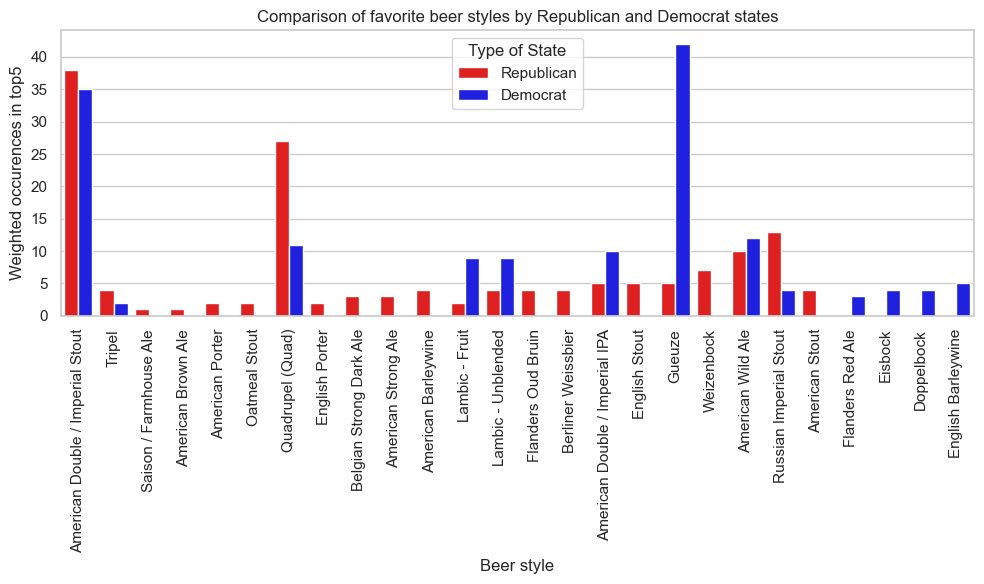

In [31]:
df_combined = pd.concat([rep_top,dem_top]).sort_values(by = ['State type'],ascending=False)
# create graphic
plt.figure(figsize=(10, 6))
sns.barplot(x='Beer styles', y='Weighted count', hue='State type', data=df_combined,palette={'Democrat': 'blue', 'Republican': 'red'})

# add labels and titles
plt.title('Comparison of favorite beer styles by Republican and Democrat states')
plt.xlabel('Beer style')
plt.ylabel('Weighted occurences in top5')
plt.xticks(rotation=90)  # rotate for better readability
plt.legend(title='Type of State')

# display graphic
plt.tight_layout()
plt.show()

In [32]:

styles_rep = []
styles_dem = []
for col in topn_republican:
    styles_rep.append(list(pd_top5_republican[col].values))
styles_rep = [item for sous_liste in styles_rep for item in sous_liste]
styles_rep = list(set(styles_rep))

for col in topn_democrat:
    styles_dem.append(list(pd_top5_democrat[col].values))
styles_dem = [item for sous_liste in styles_dem for item in sous_liste]
styles_dem = list(set(styles_dem))

# keep the values that need to be added

styles = list(set(styles_dem+styles_rep))
print(len(styles))

26


In [33]:
# add the style from top5 republican to democrat and vice versa (for the plot)
# democrats States

pd_top_democrat_rating = pd.DataFrame({
    'Top 5':np.arange(1,len(styles)+6)
})
for state in topn_democrat:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    top_state = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'mean'}).sort_values('rating',ascending=False)
    for style in styles:
        if style in top_state.index:
            pass
        else:
            top_state.loc[style] = None
    top_state = pd.concat([top_state.head(5), top_state.loc[styles]])
    #add beer styles
    pd_top_democrat_rating[state] = top_state.index
    pd_top_democrat_rating[state+'_rating'] = top_state['rating'].values #add ratings of beer_styles


# Republican States

pd_top_republican_rating = pd.DataFrame({
    'Top 5':np.arange(1,len(styles)+6)
})
for state in topn_republican:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    top_state = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'mean'}).sort_values('rating',ascending=False)
    for style in styles:
        if style in top_state.index:
            pass
        else:
            top_state.loc[style] = None
    top_state = pd.concat([top_state.head(5), top_state.loc[styles]])
    # add beer styles
    pd_top_republican_rating[state] = top_state.index
    pd_top_republican_rating[state+'_rating'] = top_state['rating'].values

In [34]:
to_leave_rep = topn_republican + ['Top 5']
to_leave_dem = topn_democrat + ['Top 5']
list_rep_rating = [item for item in list(pd_top_republican_rating.columns) if item not in to_leave_rep]
list_dem_rating = [item for item in list(pd_top_democrat_rating.columns) if item not in to_leave_dem]

In [35]:

# new long format to plot
republican_long = pd.melt(pd_top_republican_rating, id_vars=['Top 5'], value_vars=topn_republican,
                          var_name='State', value_name='Beer style')
democrat_long = pd.melt(pd_top_democrat_rating, id_vars=['Top 5'], value_vars=topn_democrat,
                          var_name='State', value_name='Beer style')

# create a new column rating
republican_long['Rating'] = pd.melt(pd_top_republican_rating, id_vars=['Top 5'], value_vars=list_rep_rating,
                                    var_name='State_rating', value_name='Rating')['Rating']
democrat_long['Rating'] = pd.melt(pd_top_democrat_rating, id_vars=['Top 5'], value_vars=list_dem_rating,
                                    var_name='State_rating', value_name='Rating')['Rating']

# add column 'state type'
republican_long['State type'] = 'Republican'
democrat_long['State type'] = 'Democrat'


# combine the dfs
df_combined = pd.concat([republican_long, democrat_long])
#display(df_combined[60:120])
df_combined = df_combined.drop_duplicates(subset=('State','Beer style'))

E:\Anaconda\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


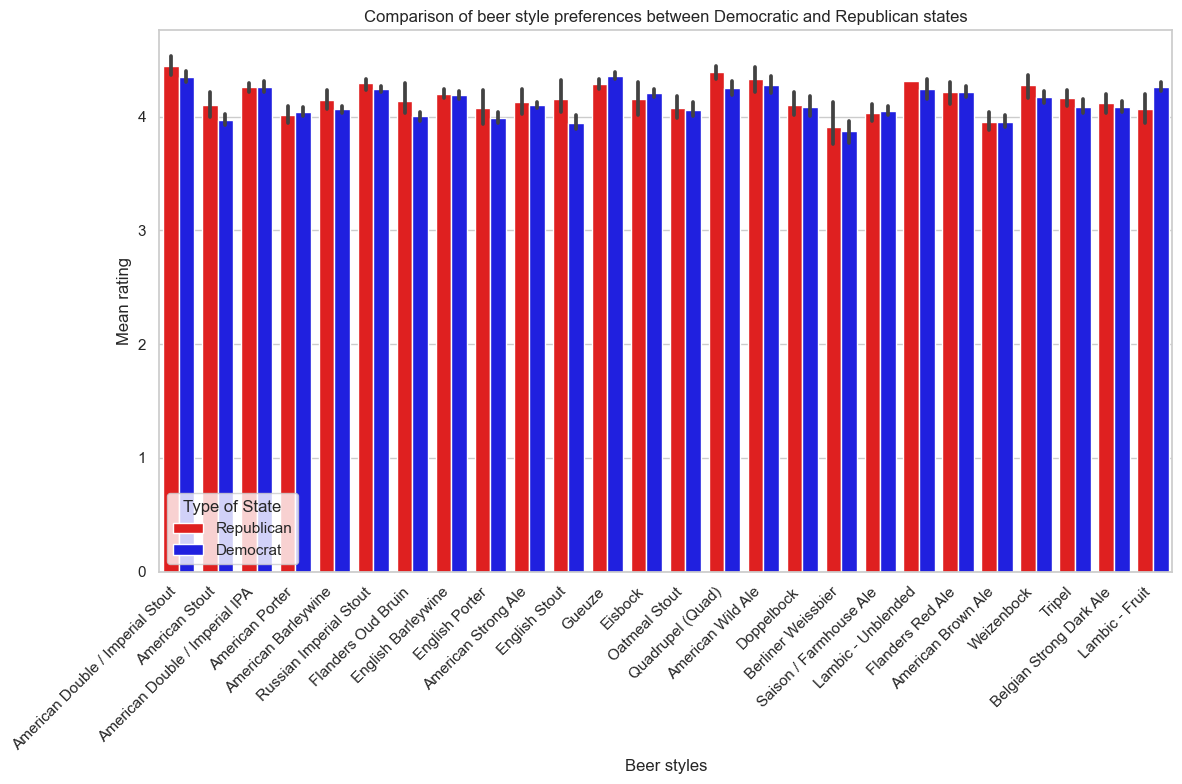

In [36]:
# create graphic
plt.figure(figsize=(12, 8))
sns.barplot(data=df_combined, x='Beer style', y='Rating', hue ='State type',palette={'Democrat': 'blue', 'Republican': 'red'})

# personnalise the graphic
plt.title('Comparison of beer style preferences between Democratic and Republican states')
plt.xlabel('Beer styles')
plt.ylabel('Mean rating')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Type of State')

# display graphic
plt.tight_layout()
plt.show()

In [37]:
### The Lambic Unblended doesn't have a lot of reviews for republican states.
# Why not analyze the popularity then, i.e nb of reviews ? 
df_test_rep = BA_usa[BA_usa['user_state'].isin(topn_republican)]
df_test_dem = BA_usa[BA_usa['user_state'].isin(topn_democrat)]
# df_test_rep[df_test_rep['beer_style']=='American Double / Imperial IPA']
print('Mean rating for Republican states\n',df_test_rep.groupby('beer_style').agg({'rating':'count'}).loc['Lambic - Unblended'],'\n')
print('Mean rating for Democrat states\n',df_test_dem.groupby('beer_style').agg({'rating':'count'}).loc['Lambic - Unblended'])

Mean rating for Republican states
 rating    164
Name: Lambic - Unblended, dtype: int64 

Mean rating for Democrat states
 rating    2295
Name: Lambic - Unblended, dtype: int64


In [38]:
# All beer styles in top 7 count for all states
rep_styles =[]
dem_styles =[]

for state in topn_democrat:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]    
    top_state_count = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'count'}).sort_values('rating',ascending=False)
    top5_style = list(top_state_count.head(7).index)
    dem_styles.append(top5_style)
for state in topn_republican:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    top_state_count = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'count'}).sort_values('rating',ascending=False)
    top5_style = list(top_state_count.head(7).index)
    rep_styles.append(top5_style)

dem_styles = [item for sous_liste in dem_styles for item in sous_liste]
rep_styles = [item for sous_liste in rep_styles for item in sous_liste]

styles = list(set(rep_styles+dem_styles))
print(styles)

['Russian Imperial Stout', 'American Amber / Red Ale', 'Fruit / Vegetable Beer', 'American Double / Imperial Stout', 'American Pale Ale (APA)', 'American IPA', 'American Double / Imperial IPA', 'American Porter', 'American Wild Ale', 'Saison / Farmhouse Ale']


In [39]:
# democrats States

pd_top_democrat_count = pd.DataFrame({
    'Top 5':np.arange(1,len(styles)+8)
})
for state in topn_democrat:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]    
    top_state_count = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'count'}).sort_values('rating',ascending=False)

    top_state_count = pd.concat([top_state_count.head(7), top_state_count.loc[styles]])
    #add beer styles
    pd_top_democrat_count[state] = top_state_count.index
    pd_top_democrat_count[state+'_count'] = top_state_count['rating'].values #add ratings of beer_styles


# Republican States

pd_top_republican_count = pd.DataFrame({
    'Top 5':np.arange(1,len(styles)+8)
})
for state in topn_republican:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    
    top_state_count = BA_state[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': 'count'}).sort_values('rating',ascending=False)
    top_state_count = pd.concat([top_state_count.head(7), top_state_count.loc[styles]])
    #add beer styles
    pd_top_republican_count[state] = top_state_count.index
    pd_top_republican_count[state+'_count'] = top_state_count['rating'].values

In [40]:
list_rep_count = [item for item in list(pd_top_republican_count.columns) if item not in to_leave_rep]
list_dem_count = [item for item in list(pd_top_democrat_count.columns) if item not in to_leave_dem]

In [41]:
#percentage of pop because imbalance in data
for state in topn_republican:
    pd_top_republican_count[state+'_count'] = pd_top_republican_count[state+'_count']/pd_top_republican_count[state+'_count'].sum()
for state in topn_democrat:
    pd_top_democrat_count[state+'_count'] = pd_top_democrat_count[state+'_count']/pd_top_democrat_count[state+'_count'].sum()

In [42]:
# new long format to plot
republican_long = pd.melt(pd_top_republican_count, id_vars=['Top 5'], value_vars=topn_republican,
                          var_name='State', value_name='Beer style')
democrat_long = pd.melt(pd_top_democrat_count, id_vars=['Top 5'], value_vars=topn_democrat,
                          var_name='State', value_name='Beer style')

# create a new column rating
republican_long['Count'] = pd.melt(pd_top_republican_count, id_vars=['Top 5'], value_vars=list_rep_count,
                                    var_name='State_rating', value_name='Count of rating')['Count of rating']
democrat_long['Count'] = pd.melt(pd_top_democrat_count, id_vars=['Top 5'], value_vars=list_dem_count,
                                    var_name='State_rating', value_name='Count of rating')['Count of rating']

# add column 'state type'
republican_long['State type'] = 'Republican'
democrat_long['State type'] = 'Democrat'


# combine the dfs
df_combined = pd.concat([republican_long, democrat_long])
df_combined = df_combined.drop_duplicates(subset=('State','Beer style'))

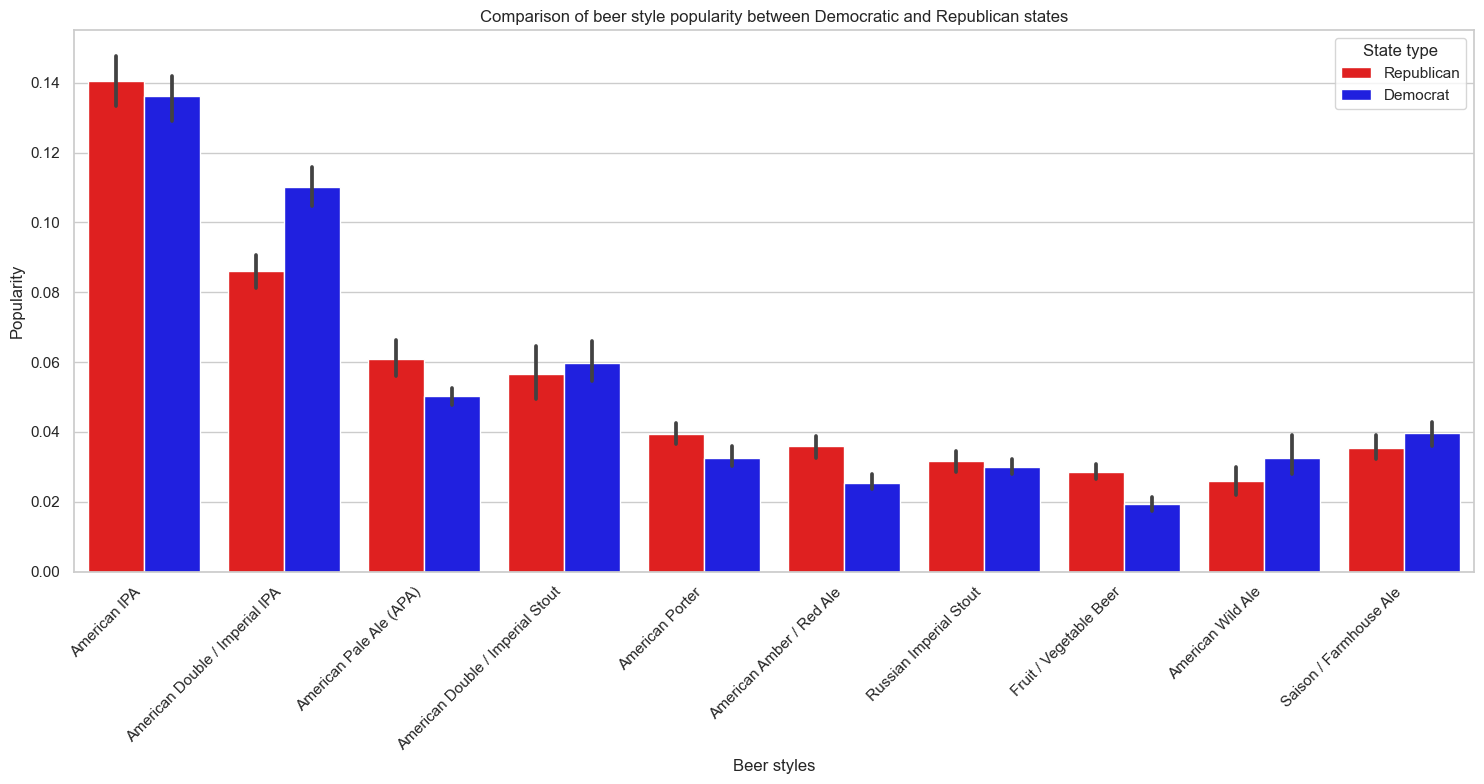

In [43]:
# Create the graph
plt.figure(figsize=(15, 8))
sns.barplot(data=df_combined, x='Beer style', y='Count', hue ='State type',palette={'Democrat': 'blue', 'Republican': 'red'})

# Title + labels
plt.title('Comparison of beer style popularity between Democratic and Republican states')
plt.xlabel('Beer styles')
plt.ylabel('Popularity')
plt.xticks(rotation=45, ha='right')  # Rotation des labels de l'axe x pour meilleure lisibilité
plt.legend(title='State type')

# Plot
plt.tight_layout()
plt.show()

In [44]:
### Only small differences in beer popularity, except for American Double/ Imperial IPA

#### 5.2.2 Average Alcohol % in Top Beers

Let's try to compare the preference in alcool percentage. 

The goal is to compute the mean beer_abv for the top 10 beer of each state.

In [45]:
# democrats States

pd_top_democrat_abv = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
for state in topn_democrat:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    #Drop rows if missing values on beer_abv
    BA_state = BA_state.dropna(axis=0,subset=['beer_abv'])
    top_state_abv = BA_state[['beer_name','beer_style','beer_abv','rating']].groupby(['beer_name']).agg({'rating': 'mean','beer_abv':'first'}).sort_values('rating',ascending=False)[:5]
    #add beer names
    pd_top_democrat_abv[state] = top_state_abv.index
    pd_top_democrat_abv[state+'_abv'] = top_state_abv['beer_abv'].values #add avg of beer_name


# Republican States

pd_top_republican_abv = pd.DataFrame({
    'Top 5':np.arange(1,6)
})
for state in topn_republican:
    BA_state = BA_usa.copy()[BA_usa['user_state']==str(state)]
    # keep the beer if it has at leat 10 ratings
    counts = BA_state.groupby('beer_id')['rating'].transform('count')
    BA_state = BA_state[counts >= 10]
    #Drop rows if missing values on beer_abv
    BA_state = BA_state.dropna(axis=0,subset=['beer_abv'])
    top_state_abv = BA_state[['beer_name','beer_style','beer_abv','rating']].groupby(['beer_name']).agg({'rating': 'mean','beer_abv':'first'}).sort_values('rating',ascending=False)[:5]
    #add beer names
    pd_top_republican_abv[state] = top_state_abv.index
    pd_top_republican_abv[state+'_abv'] = top_state_abv['beer_abv'].values #add avg of beer_name


In [46]:
list_rep_abv = [item for item in list(pd_top_republican_abv.columns) if item not in to_leave_rep]
list_dem_abv = [item for item in list(pd_top_democrat_abv.columns) if item not in to_leave_dem]

In [47]:
# new long format to plot
republican_long = pd.melt(pd_top_republican_abv, id_vars=['Top 5'], value_vars=topn_republican,
                          var_name='State', value_name='Beer name')
democrat_long = pd.melt(pd_top_democrat_abv, id_vars=['Top 5'], value_vars=topn_democrat,
                          var_name='State', value_name='Beer name')

# create a new column rating
republican_long['Beer abv'] = pd.melt(pd_top_republican_abv, id_vars=['Top 5'], value_vars=list_rep_abv,
                                    var_name='State_rating', value_name='abv')['abv']
democrat_long['Beer abv'] = pd.melt(pd_top_democrat_abv, id_vars=['Top 5'], value_vars=list_dem_abv,
                                    var_name='State_rating', value_name='abv')['abv']

# add column 'state type'
republican_long['State type'] = 'Republican'
democrat_long['State type'] = 'Democrat'


# combine the dfs
df_combined = pd.concat([republican_long, democrat_long])

2.0 % of difference in median


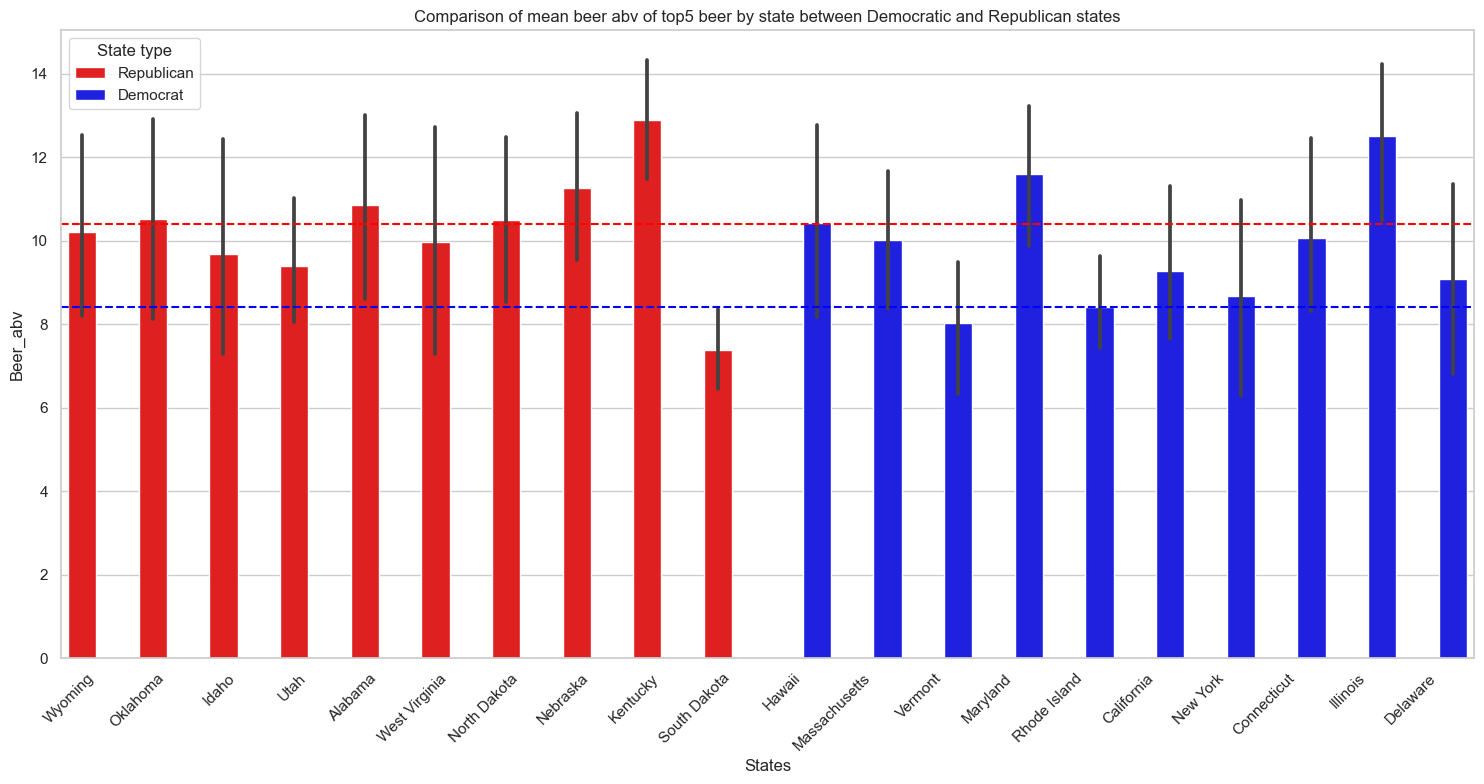

In [48]:
# Create graphic
plt.figure(figsize=(15, 8))
sns.barplot(data=df_combined, x='State', y='Beer abv', hue ='State type',palette={'Democrat': 'blue', 'Republican': 'red'})
median_rep = df_combined[df_combined['State type']=='Republican']['Beer abv'].median()
median_dem = df_combined[df_combined['State type']=='Democrat']['Beer abv'].median()
print(round(abs(median_dem-median_rep),2),'% of difference in median')
plt.axhline(y=median_rep, color='red', linestyle='--')
plt.axhline(y=median_dem, color='blue', linestyle='--')
# personnalize graphic
plt.title('Comparison of mean beer abv of top5 beer by state between Democratic and Republican states')
plt.xlabel('States')
plt.ylabel('Beer_abv')
plt.xticks(rotation=45, ha='right')  # rotate labels for better readability
plt.legend(title='State type')

# display
plt.tight_layout()
plt.show()